# Group Project: Bank marketing

## Imports:

In [15]:
import matplotlib.pyplot as plt
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import plotnine as p9
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## TODO


<br>

---

## Data Exploration

### Load Data

In [3]:
bank = pd.read_csv("Data/BankMarketing.csv")

### Data Summary

In [270]:
y_yes_ratio = bank.y.value_counts().yes / bank.y.value_counts().no
print(bank.y.value_counts())
print(y_yes_ratio)

no     36548
yes     4640
Name: y, dtype: int64
0.126956331399803


#### Exploring values `default`

In [13]:
unknown_no = bank.apply(pd.value_counts).dropna(axis=1, subset=["unknown"]).loc["unknown"]
display(unknown_no)

job           330.0
marital        80.0
education    1731.0
default      8597.0
housing       990.0
loan          990.0
Name: unknown, dtype: float64

Helper-function: `generate_ratio_df(df, column)` :  
* Takes df and a column name as input
* calculates the ratio of `yes` to `no` values of column `y` in the distinct values of the specified column
* returns a df that only contains the unique values of `column`, the `yes` and `no` counts as well as the ratio `yes/no`

In [217]:
def generate_ratio_df(df, column):
    result = df.loc[:,[column, "y", "age"]].groupby([column, "y"]).agg("count")
    result = result.unstack().reset_index()
    result.columns = result.columns.get_level_values(0)
    result.columns = [column, "y_no_count", "y_yes_count"]
    result["y_ratio"] = result["y_yes_count"] / result["y_no_count"]
    return result

#### Attribute `default`

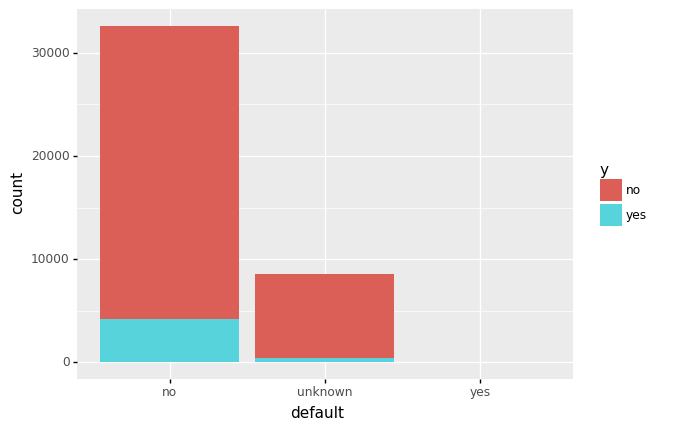

<ggplot: (-9223371890916721316)>

In [38]:
(p9.ggplot(data=bank)
        + p9.geom_bar(mapping=p9.aes(x="default", fill="y"))
)

Get default ratio and absolute numbers:

In [162]:
default_df = generate_ratio_df(bank, "default")
display(default_df)

,default,y_no_count,y_yes_count,y_ratio
0,no,28391.0,4197.0,0.147829
1,unknown,8154.0,443.0,0.054329
2,yes,3.0,NaN,NaN


What does this tell us?
* we can treat the category `unknown` as a distinct 3rd value apart from `yes` and `no`
    * it is a stronger indicator for the target value than the category `no`, whereas it seems that first of all almost no calls have been made to people with a faulty default. But for the 3 phone calls that have been made, none were successful in terms of the target variable (but that may also be because of the small sample at hand of `yes`)

<br>

#### Attribute `education`

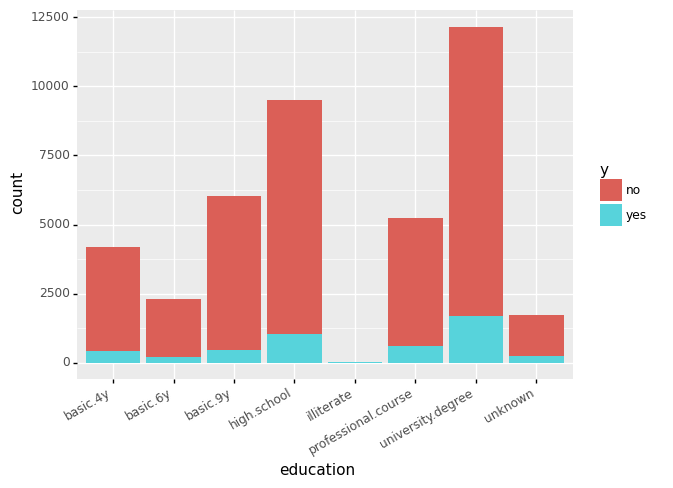

<ggplot: (-9223371890911437036)>

In [150]:
(p9.ggplot(data=bank)
        + p9.geom_bar(mapping=p9.aes(x="education", fill="y"))
        + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

Get default ratio and absolute numbers:

In [160]:
education_df = generate_ratio_df(bank, "education")

In [161]:
display(education_df)

,education,y_no_count,y_yes_count,y_ratio
0,basic.4y,3748,428,0.114194
1,basic.6y,2104,188,0.089354
2,basic.9y,5572,473,0.084889
3,high.school,8484,1031,0.121523
4,illiterate,14,4,0.285714
5,professional.course,4648,595,0.128012
6,university.degree,10498,1670,0.159078
7,unknown,1480,251,0.169595


What does this tell us?
* We can't tell if `unknown` can be treated as a valid category
    * But it has the highest ratio after `illiterate` (which is most likely to be because of the small sample of 18 cases only)
* Idea: A/B testing with and without the entries denoted as `unknown`
* Other idea: assign `university.degree` to unknown, as it is closest in terms of the `y_ratio`

<br>

### Attributes `housing` & `loan`

In [200]:
#touples = []
#for i in range(2,4):
#    for j in ["job", "marital", "education", "default", "housing", "loan"]:
#        touples.append(("housing, loan", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])))
    
unknown_comb = pd.DataFrame([
    ("housing, loan", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])),
    ("housing, loan, pdays=999", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["pdays"] == 999)])),
    ("housing, loan, default", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown")])),
    ("housing, loan, education", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["education"] == "unknown")])),
    ("housing, loan, marital", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["marital"] == "unknown")])),
    ("housing, loan, job", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["job"] == "unknown")])),
    ("housing, loan, default, education", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["education"] == "unknown")])),
    ("housing, loan, default, marital", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["marital"] == "unknown")])),
    ("housing, loan, default, job", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["job"] == "unknown")])),
    ("job, marital", len(bank.loc[(bank["job"] == "unknown") & (bank["marital"] == "unknown")])),
    ("job, education", len(bank.loc[(bank["job"] == "unknown") & (bank["education"] == "unknown")])),
    ("job, education, default", len(bank.loc[(bank["job"] == "unknown") & (bank["education"] == "unknown") & (bank["default"] == "unknown")]))   
], columns=["attributes", "unknown-count"])

display(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])

display(unknown_comb.sort_values(by="unknown-count", ascending=False))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
81,51,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
261,27,blue-collar,single,basic.6y,no,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
385,59,management,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
401,48,services,married,high.school,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40990,31,admin.,single,university.degree,no,unknown,unknown,cellular,oct,tue,...,1,3,1,success,-1.1,94.601,-49.5,1.008,4963.6,yes
41014,31,technician,single,professional.course,no,unknown,unknown,cellular,oct,thu,...,2,999,0,nonexistent,-1.1,94.601,-49.5,1.025,4963.6,yes
41015,34,admin.,divorced,university.degree,no,unknown,unknown,cellular,oct,thu,...,2,999,1,failure,-1.1,94.601,-49.5,1.025,4963.6,no
41029,46,management,married,university.degree,no,unknown,unknown,cellular,oct,mon,...,2,12,2,failure,-1.1,94.601,-49.5,1.032,4963.6,no


,attributes,unknown-count
0,"housing, loan",990
1,"housing, loan, pdays=999",956
2,"housing, loan, default",227
10,"job, education",131
11,"job, education, default",74
3,"housing, loan, education",40
6,"housing, loan, default, education",18
9,"job, marital",9
5,"housing, loan, job",5
8,"housing, loan, default, job",4


We see, that all `unknown` values of `housing` and `loan` are in the same rows.
* also a few of the `default` values are `unknown` in these rows
* The `pdays` is almost always `999` which means, that in these cases there as not been a contact between these customers and the bank before
* These results may indicate, that there will be cases where the bank encounters a new customer that it has never contacted. Based on the `unknown` values, these rows could easily be eliminated. But this will consequently also mean, that our model is not suited to deal with customers that miss some information and have never been contacted.
    * idea: we could develop 2 separate models: one that deals with "new" customers and one that deals with "known" customers. The question is, if this will improve prediction quality or not.

Checking `pdays`:

<AxesSubplot:xlabel='pdays', ylabel='Count'>

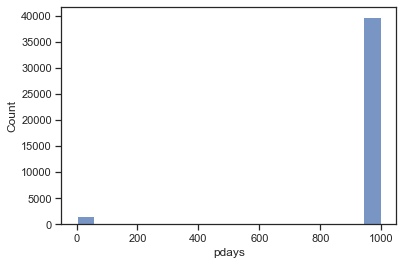

In [208]:
sns.histplot(bank.pdays)

* the `pdays` being `999` does not tell us anything?

In [265]:
pdays_df = generate_ratio_df(bank, "pdays")
temp_df = pd.DataFrame(
    [
        ["0-27",
         pdays_df.iloc[0:25,1].sum(),
         pdays_df.iloc[0:25,2].sum(),
         pdays_df.iloc[0:25,2].sum() / pdays_df.iloc[0:25,1].sum()]
    ],
    columns=["pdays",
             "y_no_count",
             "y_yes_count",
             "y_ratio"])
# reindex to have a proper concat result:
temp_df.index.values[0] = len(pdays_df)
#pdays_df = pd.concat([pdays_df.iloc[[26]], temp_df])
pdays_df = pd.concat([pdays_df, temp_df])
display(pdays_df)

,pdays,y_no_count,y_yes_count,y_ratio
0,0,5.0,10.0,2.000000
1,1,18.0,8.0,0.444444
2,2,24.0,37.0,1.541667
3,3,141.0,298.0,2.113475
4,4,55.0,63.0,1.145455
5,5,17.0,29.0,1.705882
6,6,123.0,289.0,2.349593
7,7,20.0,40.0,2.000000
8,8,6.0,12.0,2.000000
9,9,29.0,35.0,1.206897


While the `pdays` being 999 does not tell us a lot, it being some other value than 999 does: it has a great impact on the target variable!
* idea: set `pdays` to be __categorical__ with categories: `999` or `not 999`.

<br>

### Quantitative Variables

#### Some boxplots...

<AxesSubplot:>

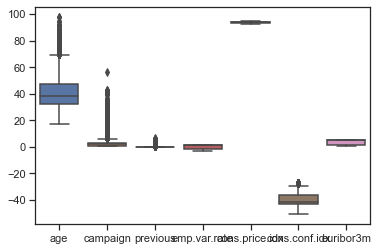

In [287]:
sns.boxplot(data=bank.loc[:,["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"]])

<AxesSubplot:>

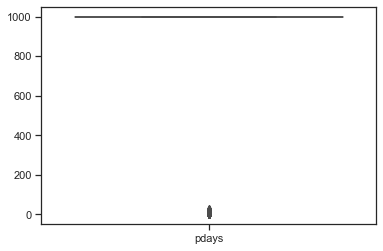

In [276]:
sns.boxplot(data=bank.loc[:,["pdays"]])

<AxesSubplot:>

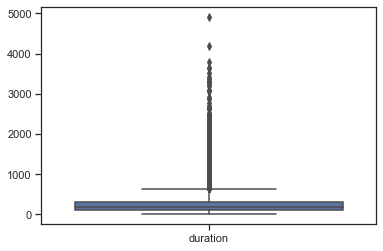

In [285]:
sns.boxplot(data=bank.loc[:,["duration"]])

<AxesSubplot:>

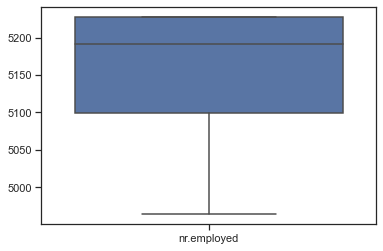

In [286]:
sns.boxplot(data=bank.loc[:,["nr.employed"]])

#### Pairplot

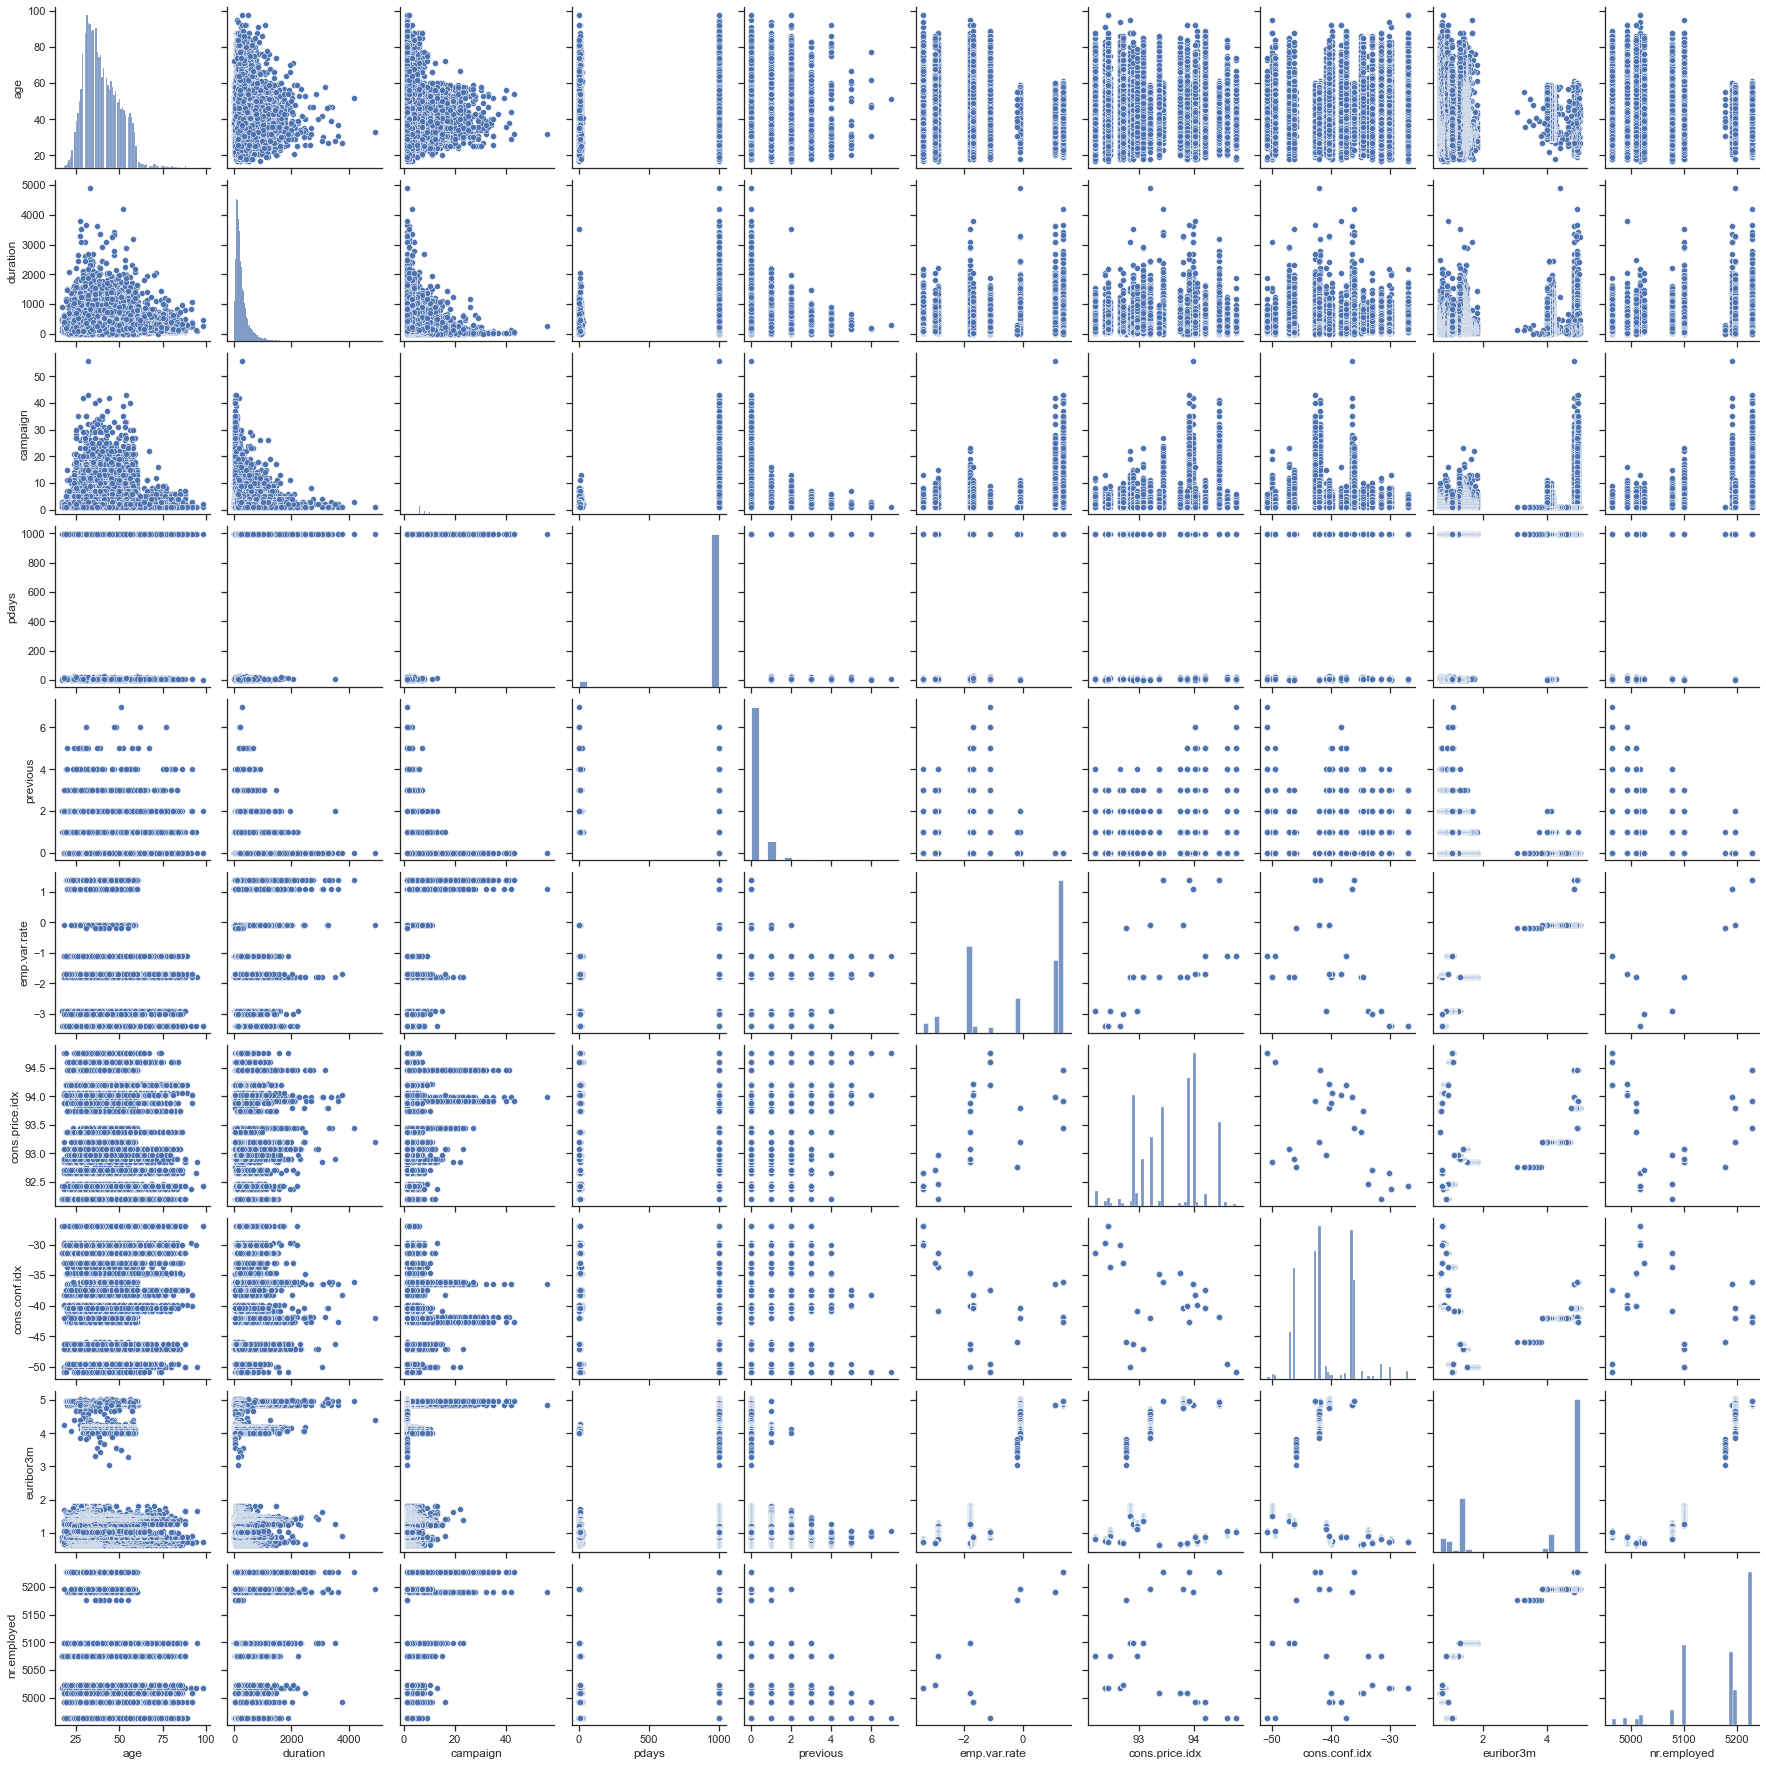

In [202]:
sns.set(style="ticks")
sns.pairplot(bank)

<br>

### Data Description

Goals:
1. Predict, if client will subscribe a term deposit
2. Decrease number of phone calls (efficiency)
3. increase total number of deposit subscriptions (effectiveness)

Measures:
* Minimize false positives (unnecessary calls)
* Maximize 

<br>

---

## Data Cleaning

<br>

---

## Data Wrangling

<br>

---

## Model Preparation

<br>

---

## Classification